In [37]:
import numpy as np
from nilearn.maskers import NiftiMasker, MultiNiftiMasker
from nilearn.image import math_img, concat_imgs, smooth_img
from nilearn.regions import RegionExtractor
from nilearn.plotting import plot_prob_atlas

import matplotlib.pyplot as plt

In [38]:
def post_process(img, threshold=95):
    extractor = RegionExtractor(
    maps_img=math_img("img[..., np.newaxis]", img=img),
        thresholding_strategy="percentile",
        threshold=threshold,
        smoothing_fwhm=20,
        min_region_size=7000,
    )
    extractor.fit()
    mask = extractor.regions_img_
    mask = math_img("np.sum(img, axis=-1)", img=mask)
    mask = math_img("img / np.max(img)", img=mask)
    return mask

In [39]:
component0 = post_process("/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_0.nii.gz", threshold=98)

In [40]:
component1 = post_process("/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_1.nii.gz", threshold=98)

In [41]:
component2 = post_process("/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_2.nii.gz", threshold=98)

In [42]:
component3 = post_process("/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_3.nii.gz", threshold=98)

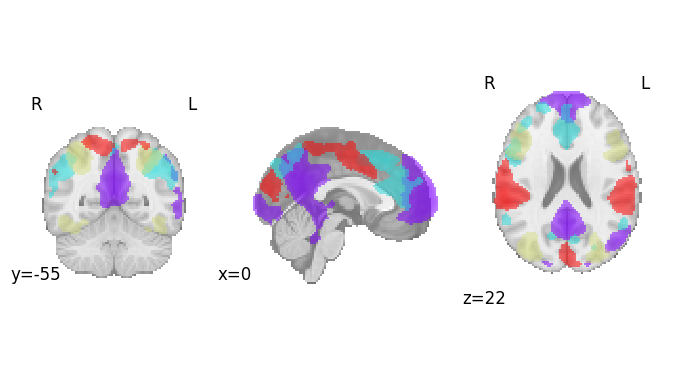

In [44]:
plot_prob_atlas(
    concat_imgs([component0, component1, component2, component3]),
    cut_coords=(0, -55, 22),
    draw_cross=False,
    radiological=True,
    cmap="rainbow"
)

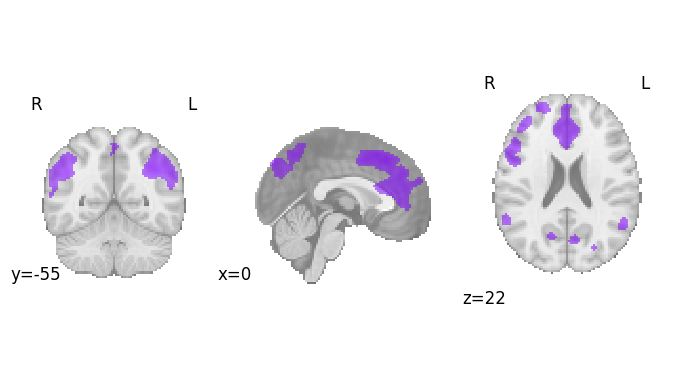

In [45]:
plot_prob_atlas(
    concat_imgs([component1]),
    cut_coords=(0, -55, 22),
    draw_cross=False,
    radiological=True,
    cmap="rainbow"
)

## Histogram of voxel intensities

In [278]:
values = []
for idx in range(4):
    masked = NiftiMasker().fit_transform(f"/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_{idx}.nii.gz")
    values.append(masked.tolist())

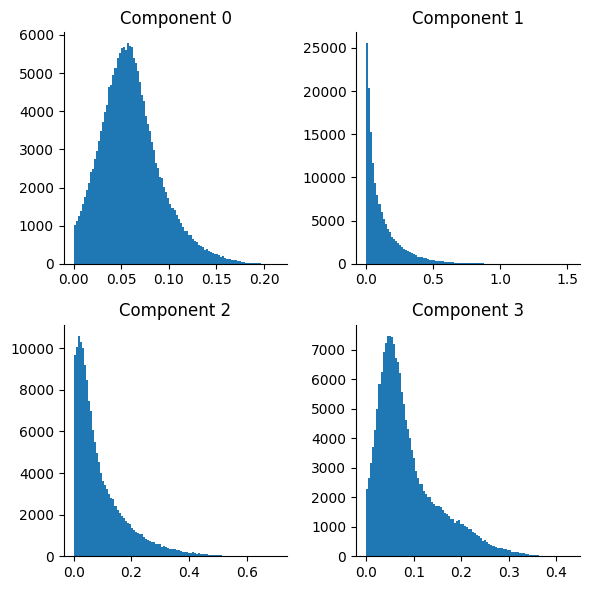

In [279]:
# Draw the histograms
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for idx, ax in enumerate(axs.flat):
    ax.hist(values[idx], bins=100)
    ax.set_title(f"Component {idx}")

    # Remove spines
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig("/Users/chris/Desktop/component_intensity_hist.png", dpi=1200)

## Get intersection mask

In [280]:
from nilearn.image import resample_to_img
ignore = [
    (0, "EVC"), (0, "HLVC"), (0, "FPN"),
    (1, "DMN"),
    (2, "DMN"), (2, "EVC"),
    (3, "EVC"), (3, "HLVC"), (3, "DMN")
]

# Product between clumped ROI and components
maps = []
labels = []
components = [f"/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error_components/components_{idx}.nii.gz" for idx in range(4)]
components = [math_img("img / np.max(img)", img=component) for component in components]

for idx, component in enumerate(components):
    for networks in ["EVC", "HLVC", "DMN", "FPN"]:
        if (idx, networks) in ignore:
            continue

        network_roi = resample_to_img(f"/Users/chris/projects/Nature2023MooneyScripts/results/clumped_rois/{networks}.nii.gz", component, interpolation="nearest")

        labels.append(f"{networks} in Component {idx}")
        maps.append(math_img("roi * component", roi=network_roi, component=component))

all_maps = concat_imgs(maps)

In [281]:
all_maps.to_filename(
    "/Users/chris/projects/Nature2023MooneyScripts/results/network_component_maps/continuous.nii"
)

In [282]:
# Are there overlaps?
count = math_img("np.sum(img != 0, axis=-1)", img=all_maps)
count.get_fdata().max()

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/nilearn/image/image.py:1071: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


6.0

In [283]:
['background'] + labels

['background',
 'DMN in Component 0',
 'EVC in Component 1',
 'HLVC in Component 1',
 'FPN in Component 1',
 'HLVC in Component 2',
 'FPN in Component 2',
 'FPN in Component 3']

In [284]:
# Make the winner-take all map
argmax_map = math_img("np.argmax(img, axis=-1)", img=all_maps)
winner_take_all = math_img("np.where(np.max(img, axis=-1) > 0.2, argmax_map + 1, 0)", img=all_maps, argmax_map=argmax_map)
winner_take_all.to_filename(
    "/Users/chris/projects/Nature2023MooneyScripts/results/network_component_maps/winner_take_all.nii"
)

In [285]:
# Make a number of maps
for idx, label in enumerate(labels):
    img = math_img(f"np.where(img == {idx} + 1, 1, 0)", img=winner_take_all)
    l = label.replace(" in Component ", "-")
    img.to_filename(
        f"/Users/chris/projects/Nature2023MooneyScripts/results/network_component_maps/{l}.nii"
    )